<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.3: Optimization in Higher Dimensions: The need for speed**

### Objective: See how and why the optimization methods propose-accept-reject and perturb-measure-step become intractably slow for higher dimensional problems, i.e. they do not scale well. See that high-dimensional problems are ubiquitous in neural systems.

In this sequence we will:

* Analytically optimize a function of many variables, using ideas and tools from calculus, generalizing our approach for two dimensions to $n$ dimensions.

* Explore how propose-accept-reject and pertrub-measure-step scale up to higher dimensions using both simulations with a simple high dimensional function and mathematical analysis.

* Introduce a slightly more complex version of the strike-no-strike problem where the decision depends on 64 features instead of 1, and develop a simple artificial neural network that can solve this problem

* Use perturb-measure-step to train this network

* Analyse what perturb-measure-step is doing at the 'synapse' level this network.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S2"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.3.1: Optimizing a Quadratic of Many Variables Analytically

Last sequence we looked at optimization problems in 2 dimensions. We solved these analytically, and also with perturb-measure-step and propose-accept-reject. Both worked okay. Now we're going to study how long it takes for these two different learning algorithms to find the optimal values as the dimension becomes higher and higher. We let $n$ denote the number of dimensions, and ask the question which value of $\mathbf{x} \in \mathbb{R}^n$ (the real valued vector in an $n$ dimensional Euclidean space), minimizes(or maximizes) the function $f(\mathbf{x})$.

For the sake of keeping our analyses as simple as possible we will work with the function

$$f(\mathbf{x}) = \sum_{i=1}^{N}x_i^2 $$

where $x_i$ denotes the $i^{th}$ element of $\mathbf{x}$.

Maybe it's obvious to you that this particular function has exactly one minimum at $\mathbf{x} = \mathbf{0}$. If not we can take the partial derivatives

$$\frac{\partial f}{\partial x_i} = 2x_i \quad \text{for } i \in \{1, \dots, n\}$$

Setting these $n$ equations equal to zero gives us that the critical point is $\mathbf{x} = \mathbf{0}$.

We also need to check the concavity (whether the curve bends upwards or downwards or some mix of the two) to see if this zero-derivative point is a maximum or a minimum (or some other kind of inflection point, we are looking for a minimum in this case). In the same way that the first partial derivatives give the slope of $f(x,y)$ in the direction of the two parameters, i.e. the slope of the tangent plane, the second derivative gives the curvature.

So we need to look at the Hessian matrix.

$$\frac{\partial^2 f}{\partial x_i^2} = 2 \quad \text{for } i \in \{1, \dots, n\}$$
$$\frac{\partial^2 f}{\partial x_i \partial x_j} = 0 \quad \text{for } i, j \in \{1, \dots, n\}, \quad i \neq j$$

So,
$$H(f) = 2 \cdot \mathbf{I}$$
Where $I$ is the identity matrix (ones on the diagonal zeros everywhere else) in $n$ dimensions. The generalization of the determinant rule in two dimensions, is that the function has a maximum or minimum if and only if all of the eigenvalues of the Hessian are positive. In general the eigenvalues of large matrices require some effort to compute, but for diagonal matrices the eigenvalues are just the entries on the diagonal. So in this case every eigenvalue is positive. In math jargon the Hessian is *positive definite*. Also the second derivatives are all positive and so we know that $\mathbf{x} = \mathbf{0}$ is a minimum.

We're not even going to try to draw you a picture of this high dimensional object.


In [2]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.3.2: Optimizing a Quadratic of Many Variables with Propose-Accept-Reject and Perturb-Measure-Step

In the previous sequences we built up our intuitions around the Propose-Accept-Reject algorithm in lower dimensions. Now we're going to try to develop our intuitions around how the number of dimensions, or scale, of the problem affects the rate at which Propose-Accept-Reject can get close to an optimal solution. Systematic comparisons of learning algorithms is notorously fraught, different meta-parameter setting (e.g. step size) can make a huge difference, and in general good meta-parameters for one alogorithm-problem combination, will be very different from the good meta-parameters for a different algorithm-problem combination. All the details kind of matter. That said we can still develop some useful intuitions about scale, by studying a very simple system.

We will keep using the simple quadratic function

$$f(\mathbf{x}) = \sum_{i=1}^{N}x_i^2 $$

and see how the rate of convergence to a good solution changes as we increase the number of dimensions. We will run our algorithms until either 1000 iterations have been completed, or the value of $f(\mathbf{x})$ is less 0.1. For ease of comparison we will initialize $\mathbf{x}$ randomly, such that $\| \mathbf{x} \| = 5$. We will first look at propose-accept-reject, where the proposals average distance from the current point, i.e. the average step size is set at $s=0.1$.

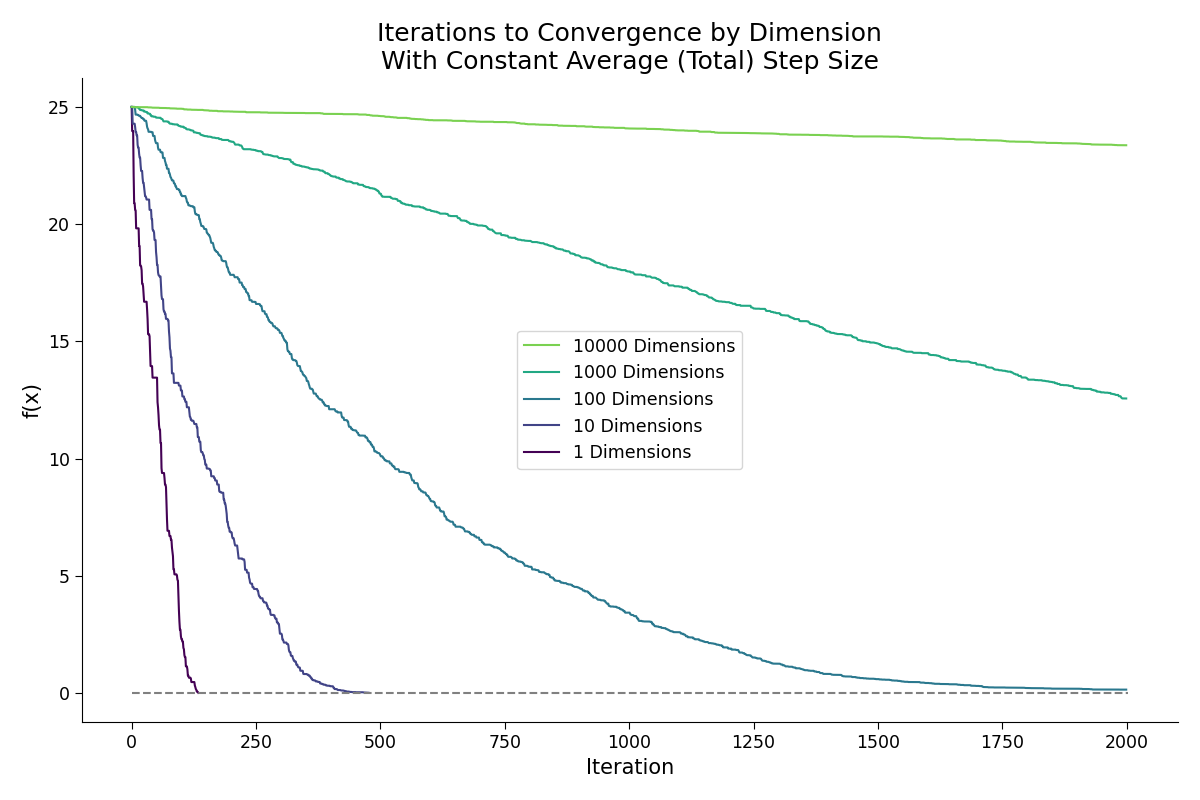

In [23]:
# @markdown **Run this cell** to see how iterations to convergence for propose-accept-reject changes as the number of dimensions increases
def simple_quadratic(x):
  return np.sum(x**2, axis=0)

def scale_stable_propose(x, step_size=0.1, rng=np.random.default_rng()):
  dim = x.shape[0]
  step_scale = step_size / np.sqrt(dim)
  proposed_x = x + rng.standard_normal(size=x.shape) * step_scale
  return proposed_x

def fixed_scale_propose(x, step_size=0.1, rng=np.random.default_rng()):
  proposed_x = x + rng.standard_normal(size=x.shape) * step_size
  return proposed_x

# propose accept reject loop
step_size = 0.1
max_proposals = 2000
starting_distance_from_optimal = 5
par_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000, 10000] # number of dimensions
x_histories = []
z_histories = []
for N in N_Dim:
  x_history = []
  z_history = []
  num_proposed = 0
  num_accepted = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size**2:
    proposed_x = scale_stable_propose(x, step_size=step_size, rng=par_rng)
    num_proposed += 1
    z_proposed = simple_quadratic(proposed_x)
    if z_proposed < z:
      x = proposed_x
      z = z_proposed
      num_accepted += 1
    x_history.append(x)
    z_history.append(z)
    if num_proposed > max_proposals:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plotting the data
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color=colors[ii])
ax.hlines(step_size**2, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Iterations to Convergence by Dimension\nWith Constant Average (Total) Step Size')
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles, labels)
plt.show()

The proposals in propose-accept-reject are generated by adding Gaussian noise to the current $\mathbf{x}$ value that is

$$
\mathbf{x}_{\text{proposed}} = \mathbf{x}_{\text{current}} + \mathbf{\xi}
$$

with $\mathbf{\xi} \sim \sigma \cdot \mathcal{N}(\mathbf{0}, \mathbf{I})$. The average size of a perturbation, i.e., its Euclidean length $\|\mathbf{\xi} \|$, is given by

$$ \begin{align}
\mathbb{E}[\|\mathbf{\xi} \|] &= \mathbb{E}\left[\sqrt{\sum_{i=1}^n \xi_i^2}\right] = \sigma \mathbb{E}[\chi_n] = \sigma \sqrt{2} \frac{\Gamma\left(\frac{n+1}{2}\right)}{\Gamma\left(\frac{n}{2}\right)} \\
&\approx \sigma \sqrt{n} \ \text{for large } n.
\end{align}$$

Here $\chi_n$ denotes a chi distribution with $n$ degrees of freedom, representing the distribution of the norm of a vector of $n$ independent standard normal random variables. ($\Gamma$ denotes the gamma function which is a generalization of the factorial function on integers to real and complex values.) For high dimensions, i.e., large $n$, the approximation $\sigma \sqrt{n}$ becomes increasingly accurate due to the central limit theorem.

Thus to have a consistent average proposal step length, $s$, we need to have $\sigma = \frac{s}{\sqrt{n}}$. If instead have a constant $\sigma$ as dimension increase, the average sizes of the steps will increase as the number of the dimensions increases. This is problematic as illustrated below.

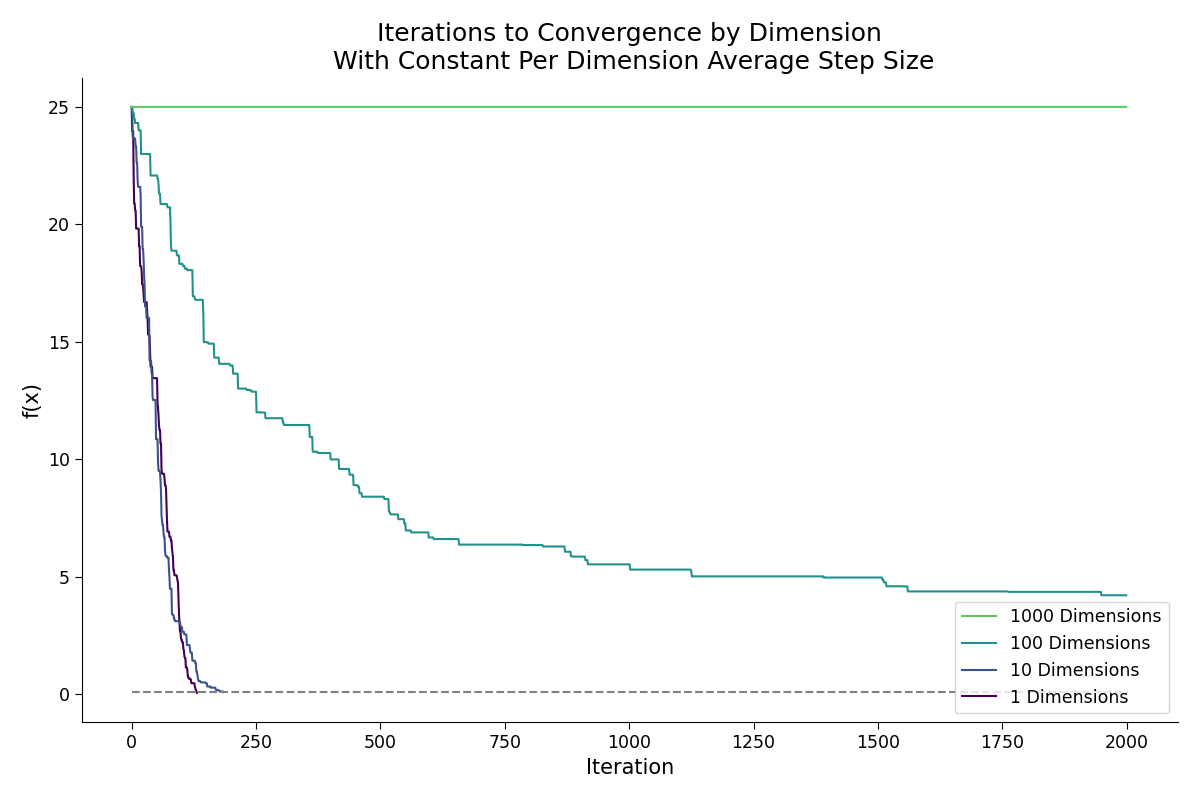

In [4]:
# @markdown **Run this cell** to see how having step size increase with dimension is a problem for propose-accept-reject.
# propose accept reject loop
step_size = 0.1
starting_distance_from_optimal = 5
par_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000] # number of dimensions
x_histories = []
z_histories = []
max_proposals = 2000
for N in N_Dim:
  x_history = []
  z_history = []
  num_proposed = 0
  num_accepted = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size:
    proposed_x = fixed_scale_propose(x, step_size=step_size, rng=par_rng)
    num_proposed += 1
    z_proposed = simple_quadratic(proposed_x)
    if z_proposed < z:
      x = proposed_x
      z = z_proposed
      num_accepted += 1
    x_history.append(x)
    z_history.append(z)
    if num_proposed > max_proposals:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plotting the data
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color= colors[ii])
ax.hlines(0.1, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Iterations to Convergence by Dimension\n With Constant Per Dimension Average Step Size')
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles, labels)
plt.show()

Having step size scale up with dimension can lead to fast convergence at first (bigger step sizes means you get where you're going more quickly) but at some point large step sizes make it more difficult to zero in on the exact location of the optimal value. Larger step sizes limit percision, eventually to the point where no improvment is made.

Now that we've seen what increasing the number of dimensions does to convergence rate of propose-accept-reject, let's take a look at perturb-measure-step.

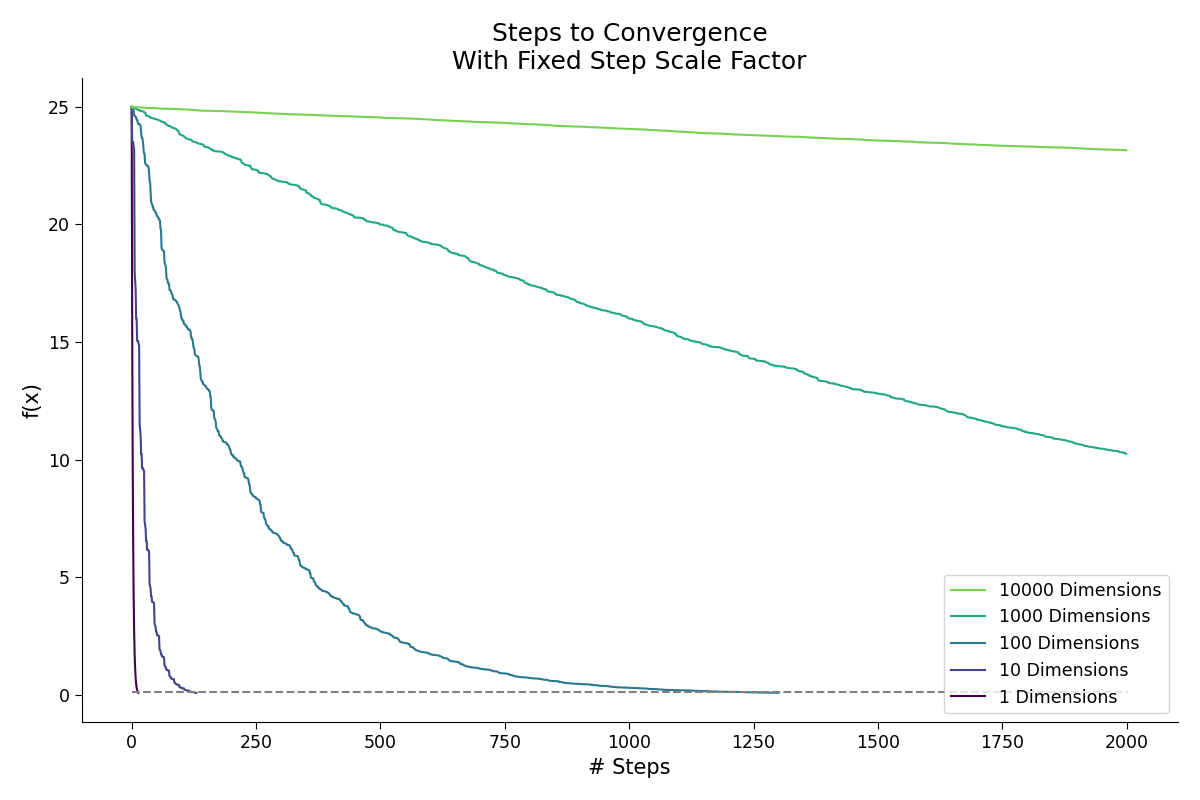

In [5]:
# @markdown **Run this cell** to look at convergence rates in different dimensions for perturb-measure-step
test_perturb = 0.00001
step_scale = 0.1
starting_distance_from_optimal = 5
pms_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000, 10000] # number of dimensions
x_histories = []
z_histories = []
max_steps = 2000
for N in N_Dim:
  x_history = []
  z_history = []
  num_steps = 0
  num_function_evaluations = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  num_function_evaluations += 1
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size:
    for dim in range(N):
      x[dim] += test_perturb #perturb
      z_test = simple_quadratic(x) #test
      x[dim] -= test_perturb # un-perturb
      dim_grad_est = (z_test - z) / test_perturb #measure slope
      x[dim] -= step_scale * dim_grad_est #step
      num_steps += 1
      z = simple_quadratic(x)
      num_function_evaluations += 2
      x_history.append(x)
      z_history.append(z)
      if num_steps > max_steps:
        break
    if num_steps > max_steps:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plot each dimensions history
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color= colors[ii])
ax.hlines(0.1, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('# Steps')
ax.set_ylabel('f(x)')
ax.set_title('Steps to Convergence\nWith Fixed Step Scale Factor')
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles, labels)
plt.show()

The number of iterations here to convergence increases with dimension, partly because, this version of perturb-measure-step basically treats each dimension in isolation. It perturbs, then measures, thens step in one dimension before moving on to the next, so $n$ steps are required to make improvements in all $n$ dimensions. In the case above where we have 10,000 dimensions, but only run for 2000 steps, 8000 of the elements of $\mathbf{x}$ have been not been improved upon at all. Scale is important for the brain. Recall that there are trillions of synapses in the brains of brainy animals. Learning in the brain requires optimzation algorithms that are effective in high dimensions. The rest of the book is dedicated to learning about algorithms that scale well in this sense, but before we get to those we want to spend just a little more time understanding how and why these two algorithms, propose-accept-reject and perturb-measure-step, slow down the way they do in higher dimensions.

# 2.1.3.3 How and Why Propose-Accept-Reject Slows Down in Higher Dimensions

The proposals in propose-accept-reject are generated by adding Gaussian noise to the current $\mathbf{x}$ value that is
$$
\mathbf{x}' = \mathbf{x} + \mathbf{\xi}
$$
with $\mathbf{\xi} \sim \frac{s}{\sqrt{n}} \cdot \mathcal{N}(\mathbf{0}, \mathbf{I})$. We scale each perturbation by $\frac{s}{\sqrt{n}}$ so that $\mathbb{E}\left[\| \mathbf{\xi} \|\right] = s$. If we reject a proposal the improvement is zero.

To get some intuition about this process let's start with a point in our simple quadratic function, and then sample lot's of Gaussian proposals around that point. If the proposal results in an improvement we will measure the angle between the direction of maximal improvment (the gradient) the proposal that would have been accepted. Then we will plot the distribution of these angles of proposals that would be accepted.



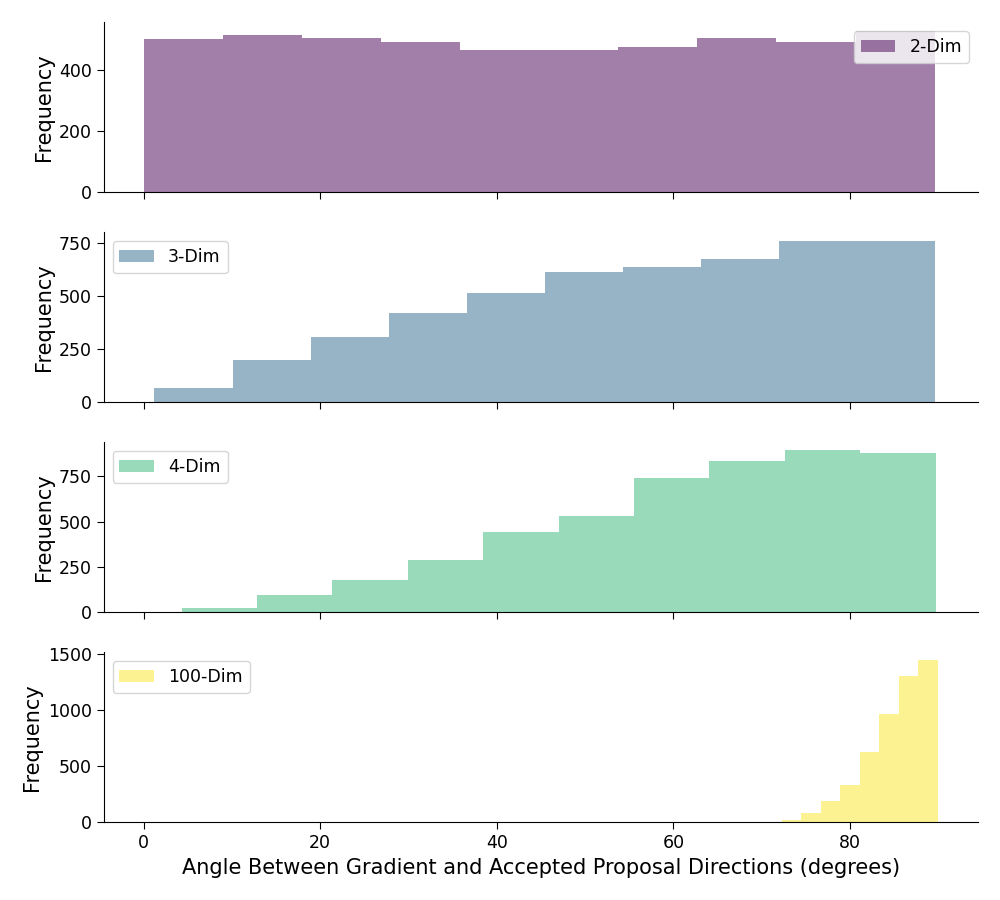

In [24]:
# @markdown **Run this cell** to see how the distribution of angles of divergence between accepepted proposals and the gradient changes with the number of dimensions.
def simple_quadratic(x):
    return np.sum(x**2, axis=0)

N_Dim = [2, 3, 4, 100]
sample_rng = np.random.default_rng(0)
step_size = 0.1
starting_distance_from_optimal = 5
num_samples = 10000

fig, axes = plt.subplots(nrows=len(N_Dim), sharex=True, figsize=(10, 9))
colors = plt.cm.viridis(np.linspace(0, 1, len(N_Dim)))  # Colormap to differentiate dimensions
remove_ip_clutter(fig)

for idx, N in enumerate(N_Dim):
  raw_x = sample_rng.standard_normal(size=N)
  unit_x = raw_x / np.linalg.norm(raw_x)
  x = unit_x * starting_distance_from_optimal
  unit_grad_x = unit_x[:, np.newaxis]  # reshape for broadcasting
  current_z = simple_quadratic(x)
  samples = sample_rng.standard_normal(size=(N, num_samples))
  unit_samples = samples / np.linalg.norm(samples, axis=0, keepdims=True)
  test_points = x[:, np.newaxis] + unit_samples * step_size / np.sqrt(N)
  test_evals = simple_quadratic(test_points)
  accepted_index = test_evals < current_z
  proportion_accepted = np.sum(accepted_index) / num_samples
  accepted_proposal_directions = unit_samples[:, accepted_index]
  dot_product = np.sum(accepted_proposal_directions * -unit_grad_x, axis=0)
  angle_from_grad = np.arccos(np.clip(dot_product, -1.0, 1.0))
  angles_in_degrees = np.degrees(angle_from_grad)
  ax = axes[idx]
  ax.hist(angles_in_degrees, alpha=0.5, color=colors[idx], label=f'{N}-Dim')
  if idx == len(N_Dim)-1:
    ax.set_xlabel('Angle Between Gradient and Accepted Proposal Directions (degrees)')
  ax.legend()
  ax.set_ylabel('Frequency')
plt.show()

Looking at these plots we see that in only 2-dimensions, a random accepted proposal direction has an angle of divergence from the gradient that is uniformly distributed between 0 and 90 degrees. As we go into higher dimensions this distribution skews towards 90 degrees (less aligned). Roughly the intuition here is that only accepting proposals that lead to improvement ensures that we have some alignment with the gradient direction, i.e. we only accept angles of divergence below 90 degrees), but in higher dimensions there is a real sense in which there are more more directions to go in, and so the degree of alignment between a random direction and any particular direction converges towards 90 degrees. Put another way, in high dimensional spaces two random directions are almost totally perpendicular to eachother. This is very different from what we may be used to when thinking about directions in two and three dimensional spaces, and is at the root of why perturb-measure-step and propose-accept-reject slow down in high dimensions, there are simply more directions to go, more directions to be explored.

## Propose-Accept-Reject Analysis
What does this fact about high-dimensional spaces (that most directions are perpendicular to eachother) mean for the expected improvement from applying an iteration propose-accept-reject?

We're going to step away from our simple quadratic function and try to say something a little more general, using an analytical approach. For this we consider a function $f(\mathbf{x})$ that is *analytic*. This has a precise mathematical meaning, but intuitively it means that the function is not pathologically wiggly. More formally, an analytic function can be locally expressed by a convergent power series. For our purposes, this implies smoothness and the absence of abrupt changes, which in turn allows for reliable use of linear approximations in the vicinity of any point within its domain. Specifically, the function can be approximated as:

$$
f(\mathbf{x} + \mathbf{p}) \approx f(\mathbf{x}) + \mathbf{p} \cdot \mathbf{g}
$$

where $\mathbf{g} = \nabla f(\mathbf{x}) = \left. \left(\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \dots, \frac{\partial f}{\partial x_n} \right)\right|_{\mathbf{x}}$ is the gradient of $f$ evalutated at $\mathbf{x}$, $\mathbf{p}$ is a small perturbation vector in $\mathbb{R}^n$, and $\mathbf{p} \cdot \mathbf{g}$ is the inner product of the two vectors.
Note that this approximation is only good when the perturbation $\mathbf{\p}$ is sufficiently small. Our assumption about $f$ being analytic means that we can make this approximation arbitrarily good, by making $\mathbf{p}$ smaller, specifically as $\|\mathbf{\delta}\|$ decreases in magnitude, higher-order terms in the Taylor expansion of $f$ at $\mathbf{x}$ become insignificant, and the linear approximation becomes increasingly accurate.

Now we ask, for any analytic function, at any point $\mathbf{x}$, with a given step size $s$, what is the average expected improvement from a single interation of the propose-accept-reject algorithm, and how does this expected improvement compare to the 'best possible' improvement of taking a step of size $s$ in the direction of the gradient?

We haven't said what $\mathbf{g}$ is or what $f$ is, so at first glance it may seem crazy to try and compute this, but we're about to do a sneaky math trick so pay attention. We're going to do a change of coordinates. The perturbations that we use in propose-accept-reject, $\mathbf{\xi}$, are samples from a little Guassian cloud, and the density of this cloud is isotropic. Isotropic means the same in all radial dimensions, so that any rigid rotation of coordinates leaves the distribution totally unchanged. Now, $\mathbf{g}$ can be re-written as the product of a unit direction vector $\frac{\mathbf{g}}{\|\mathbf{g}\|}$ and a magnitude $\|\mathbf{g}\|$. Then we can rotate our coordinate axis so that our first coordinate dimension is perfectly aligned with the gradient, and all other $n-1$ dimensions are perfectly unaligned, i.e. perpendicular, to the gradient. In this new coordinate system $\mathbf{g} = \|\mathbf{g}\|(1, 0, \cdots, 0)$, and then the inner product, $\xi \cdot \mathbf{g}$, is simply $$(\xi_1 \cdot 1 + \xi_2 \cdot 0 + \dots + \xi_n \cdot 0) \|\mathbf{g}\| = \xi_1 \|\mathbf{g}\|$$

Now that is the inner product of the gradient with any proposal, but we are interested in the inner product between the gradient and an accepted proposal, that is $\mathbb{E}\left[\xi_1 | \text{Proposal Accepted} \right] = s \sqrt{\frac{2}{n \pi}}$, since the proposal will only be accepted if $\xi_1 > 0$, so while $\xi_1$ follows a normal distribution with $\sigma = \frac{s}{\sqrt{N}}$, when we condition on acceptance $\xi_1 | \text{acceptance}$ follows a half-normal or chi-squred with one degree of freedom, $\chi_1$, distribution.

The mean of a half-normal distribution is known to be the standard deviation of the underlying normal distribution, in our case, $\frac{s}{\sqrt{n}}$ scaled by $\sqrt{\frac{2}{\pi}}$. This gives us the expected improvement from an accepted proposal as
$$s \|\mathbf{g}\| \sqrt{\frac{2}{n \pi}}$$

Now by the symmetry of the normal distribution, we can see that half of the time our proposals will be rejected and half of the time they will be accepted. When a proposal is rejected there is zero improvement. Taking the average over cases when the proposal is accepted and when it is rejected we have an expected improvement of
$$ \frac{s\|\mathbf{g}\|}{\sqrt{2\pi n}}$$

Now if we were to just know the direction of $\mathbf{g}$ and step $s$ in that direction, the improvement would be $s\|\mathbf{g}\|$. So we see that the rate of improvement relative to the optimally oriented small step is reduced by a factor of $\frac{1}{\sqrt{2 \pi n }}$. Intuitively as the number of dimensions increases, random step directions are less and less likely to be well aligned with this optimal direction. Note that if we were to use our 'always-step' variant of propose-accept-reject, we could do a little better with
$$s \|\mathbf{g}\| \sqrt{\frac{2}{n \pi}}$$ but we would still have our expected improvement per step drop of with $\frac{1}{\sqrt{n}}$

Another way to think about this, is that our acceptance criteria means we take steps that are oriented in the same half-space as the gradient. The average of many such steps will converge on the gradient, but convergence will be slow in high dimensions, since accepted proposals are a very noisy (though un-biased) estimator of the gradient. Run the following cell to see how pooling together many accepted proposal gives better alignement (closer to zero degrees of divergence), with the direction of greatest improvement, the gradient.

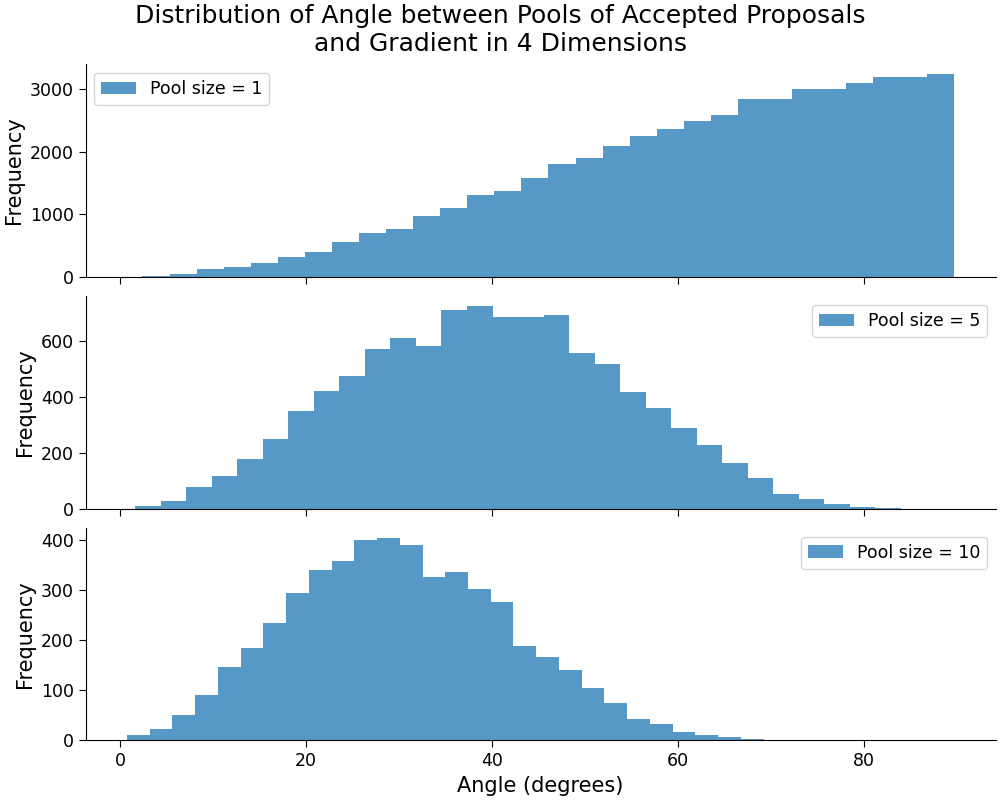

In [7]:
# @markdown **Run this cell** to see how the average of many accepted proposals has increased alignment with the gradient.
N = 4  # Fixed dimension
pool_sizes = [1, 5, 10]  # Different sizes of accepted samples to average
sample_rng = np.random.default_rng(0)
step_size = 0.1
starting_distance_from_optimal = 5
num_samples = 100000

fig, axes = plt.subplots(nrows=len(pool_sizes), sharex=True, figsize=(10, 8), constrained_layout=True)
fig.suptitle('Distribution of Angle between Pools of Accepted Proposals\nand Gradient in 4 Dimensions')

raw_x = sample_rng.standard_normal(size=N)
unit_x = raw_x / np.linalg.norm(raw_x)
x = unit_x * starting_distance_from_optimal
unit_grad_x = unit_x  # Reshape removed as it's not necessary for dot product calculation
current_z = simple_quadratic(x)
samples = sample_rng.standard_normal(size=(N, num_samples))
unit_samples = samples / np.linalg.norm(samples, axis=0, keepdims=True)
test_points = x[:, np.newaxis] + unit_samples * step_size / np.sqrt(N)
test_evals = simple_quadratic(test_points)
accepted_index = test_evals < current_z
accepted_proposal_directions = unit_samples[:, accepted_index]

for idx, sample_size in enumerate(pool_sizes):
  ax = axes[idx]
  num_groups = accepted_proposal_directions.shape[1] // sample_size
  angles_in_degrees = []
  for i in range(num_groups):
    # Compute the mean direction for each group
    group_pooled_direction = np.sum(accepted_proposal_directions[:, i * sample_size:(i + 1) * sample_size], axis=1)
    group_unit_direction = group_pooled_direction / np.linalg.norm(group_pooled_direction)  # Normalize
    dot_product = np.dot(group_unit_direction, -unit_grad_x)
    angle_from_grad = np.arccos(np.clip(dot_product, -1.0, 1.0))
    angles_in_degrees.append(np.degrees(angle_from_grad))

  ax.hist(angles_in_degrees, bins=30, alpha=0.75, label=f'Pool size = {sample_size}')
  if idx == len(pool_sizes)-1:
    ax.set_xlabel('Angle (degrees)')
  ax.set_ylabel('Frequency')
  ax.legend()

plt.show()

# 2.1.3.4 How and Why Perturb-Measure-Step Slows Down in Higher Dimensions

In pertrub-measure-step we iterate through the dimensions generating a test point according to
$$
\mathbf{x}' = \mathbf{x} + s_{\text{test}}\mathbf{e}^i
$$
Where $\mathbf{e}^i$ is an ortho-normal basis vector for the $i^{th}$ dimension. By measuring the change caused by this perturbation we can get a good estimate of the $g_i$, the component of the gradient in along the $i^{th}$ coordinate dimension. Based on this estimate of $g_i$ we then steps $s \cdot g_i$ in the $i^{th}$ dimension. Now because we don't know anything about the particular structure of $\mathbf{g}$ and the function $f$, it hard to say much about what kind of improvement we will get out of any one step in any one dimension. But we do know that after iterating through all $n$ dimensions we will have taken a step roughly in the direction of the gradient, and that the length of this combination of $n$-steps is $\sqrt{\sum_{i=1}^{n} s^2 g_i^2} = s \|\mathbf{g}\| $. Now the rate of improvement in the direction of the gradient is $\|\mathbf{g}\|$, so the expected improvement over $n$ steps will be roughly $ s\|\mathbf{g}\|^2$. Then on average, each step will contribute an improvement of

$$\frac{s\|\mathbf{g}\|^2}{n}$$

The rate of improvement for perturb-measure-step drops off with $\frac{1}{n}$, even faster than that of propose-accept-reject. This analysis is a little loose, since $\mathbf{g}$ will change slightly as steps are taken, but it could be tightened up by analyzing a more tractable "stochastic" variant of pertrub-measure-step, in which instead of iterating through the directions systematically, a random direction is chosen for perturbation. This random direction could be chosen from the $n$ orthonormal basis directions, in which case the analysis is much as above, or the direction could be choose uniformly over all possible directions, i.e. using $$
\mathbf{x}' = \mathbf{x} + s_{\text{test}}\frac{\xi}{\|\xi\|}
$$
With $\mathbf{\xi} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. (This shoud be starting to remind you of our analysis of propose-accept-reject.)

That's the perturbation. Now we want to measure the improvement in the direction of the perturbation. Which, can be computed as follows for small perturbations (because our function is analytic),
$$\frac{\Delta f(\mathbf{x})}{\|\xi \|} \approx \frac{\xi \cdot \mathbf{g}}{\| \xi \|}$$

Then we can do our same coordinate rotating trick to get the expected measured rate of improvement in the direction of $\xi$ as
$$ \frac{\xi \cdot \mathbf{g}}{\| \xi \|}  = \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|} (\xi_1 \cdot 1 + \xi_2 \cdot 0 + \dots + \xi_n \cdot 0) = \xi_1 \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|}$$.

The algorithm will then takes a step proportional to the rate of improvement, i.e. of length $s \xi_1 \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|}$ in the direction of $\xi$ and this will result in an expected improvement of $$ s \| \mathbf{g}\|^2  \frac{\xi_1^2}{\| \mathbf{\xi}\|^2}$$.

$\xi_1^2$ \| follows a $\chi^2_1$ distribution and $\|\mathbf{\xi}\|^2$ follows a $\chi^2_n$ distribution. The normalized ratio of independent $\chi^2$ distributions follows an F-distribution, i.e.
$$ n \frac{\chi^2_1}{\chi^2_n} \sim F(1,n)$$

In our case, $\xi_1^2$ and $\|\mathbf{\xi}\|^2$ are not independent at all. Just the opposite, $\xi_1$ is a component of the sum that determines $\|\mathbf{\xi}\|^2$, but for large $n$ this contribution becomes negligable and we can approximate the true distribution using an F-distribution, that is

$$\mathbf{E}\left[ s \| \mathbf{g}\|^2  \frac{\xi_1^2}{\| \mathbf{\xi}\|^2}\right] \approx \frac{s \| \mathbf{g}\|^2}{n-2}$$

In either version of perturb-measure-step the expected improvement per step drops off like $\frac{1}{n}$ as the number of dimensions increases.

Now this 'stochastic' perturb-measure-step might seem a lot like propose-accept-reject on the face of things, and they are indeed deeply related. Both essentially take a step in a radom direction, that is oriented in the same half-space as the gradient (or negative of the gradient if we are minimizing), but whereas propose-accept-reject has a fixed average step size of $s$, perturb-measure-step, *scales* its step size by factor of $s$ while taking step *proportional* to the rate of improvement in the tested direction. Thus if the test direction happens to be relatively well aligned with the gradient, it will take a bigger step, and if the test direction is relatively less aligned with gradient a smaller step is taken.

## Perturb-Measure-Step Analysis

Okay now the same for perturb-measure-step. In pertrub-measure-step we iterate through the dimensions generating a test point according to
$$
\mathbf{x}' = \mathbf{x} + s_{\text{test}}\mathbf{e}^i
$$
Where $\mathbf{e}^i$ is an ortho-normal basis vector, for the $i^{th}$ dimension. By measuring the change caused by this perturbation we can get a good estimate of the $g_i$, the component of the gradient in the $i^{th}$ dimension. Based on this the estimate of $g_i$ we then steps $s \cdot g_i$ in the $i^{th}$ dimension. Now because we don't know anything about the particular structure of $\mathbf{g}$ and the function $f$, it hard to say much about what kind of improvement we will get out of any one step in any one dimension, but we do know that after iterating through all $n$ dimensions we will have taken a step roughly in the direction of the gradient, and that the length of this combination of $n$-steps is $\sqrt{\sum_{i=1}^{n} s^2 g_i^2} = s \|\mathbf{g}\| $. Now the rate of improvement in the direction of the gradient is $\|\mathbf{g}\|$, so the expected improvement over $n$ steps will be roughly $ s\|\mathbf{g}\|^2$. Then on average, each step will contribute an improvement of

$$\frac{s\|\mathbf{g}\|^2}{n}$$

The rate of improvement for perturb-measure-step drops off with $\frac{1}{n}$, even faster than that of propose-accept-reject. This analysis is a little loose, since $\mathbf{g}$ will change slightly as steps are taken, but it could be tightened up by analyzing a more tractable "stochastic" variant of pertrub-measure-step, in which instead of iterating through the directions systematically, a random direction is chosen for perturbation. This random direction could be chosen from the $n$ orthonormal basis directions, in which case the analysis is much as above, or the direction could be choose uniformly over all possible directions, i.e. using $$
\mathbf{x}' = \mathbf{x} + s_{\text{test}}\frac{\xi}{\|\xi\|}
$$
With $\mathbf{\xi} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. Then we can do our same coordinate shifting trick to get the expected rate of improvement in the direction of $\xi$ as
$$ \frac{\xi}{\| \xi \|} \cdot \mathbf{g} = \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|} (\xi_1 \cdot 1 + \xi_2 \cdot 0 + \dots + \xi_n \cdot 0) = \xi_1 \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|}$$.

The algorithm will then take a step of length $s \xi_1 \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|}$ in the direction of $\xi$ and this will result in an improvement of $$ s \| \mathbf{g}\|^2  \frac{\xi_1^2}{\| \mathbf{\xi}\|^2}$$.

Now $\xi_1^2$ \| follows a $\chi^2_1$ distribution and $\|\mathbf{\xi}\|^2$ follows a $\chi^2_n$ distribution. Now the normalized ratio of $chi^2$ distribution follows an F-distribution, i.e.
$$ n \frac{\chi^2_1}{\chi^2_n} \sim F(1,n)$$

Now, $\xi_1^2$ and $\|\mathbf{\xi}\|^2$ are not independent at all. Just the opposite $\xi_1$ is a component of the sum that determines $\|\mathbf{\xi}\|^2$, but for large $n$ this contribution becomes negligable and can approximate the true distribution using a F-distribution, that is

$$\mathbf{E}\left[ s \| \mathbf{g}\|^2  \frac{\xi_1^2}{\| \mathbf{\xi}\|^2}\right] \approx \frac{s \| \mathbf{g}\|^2}{n-2}$$

In either version of perturb-measure-step the expected improvement per step drops off like $\frac{1}{n}$ as the number of dimensions increases.

Run the following cell to see how well this analysis lines up with a simulation on our simple quadratic function.

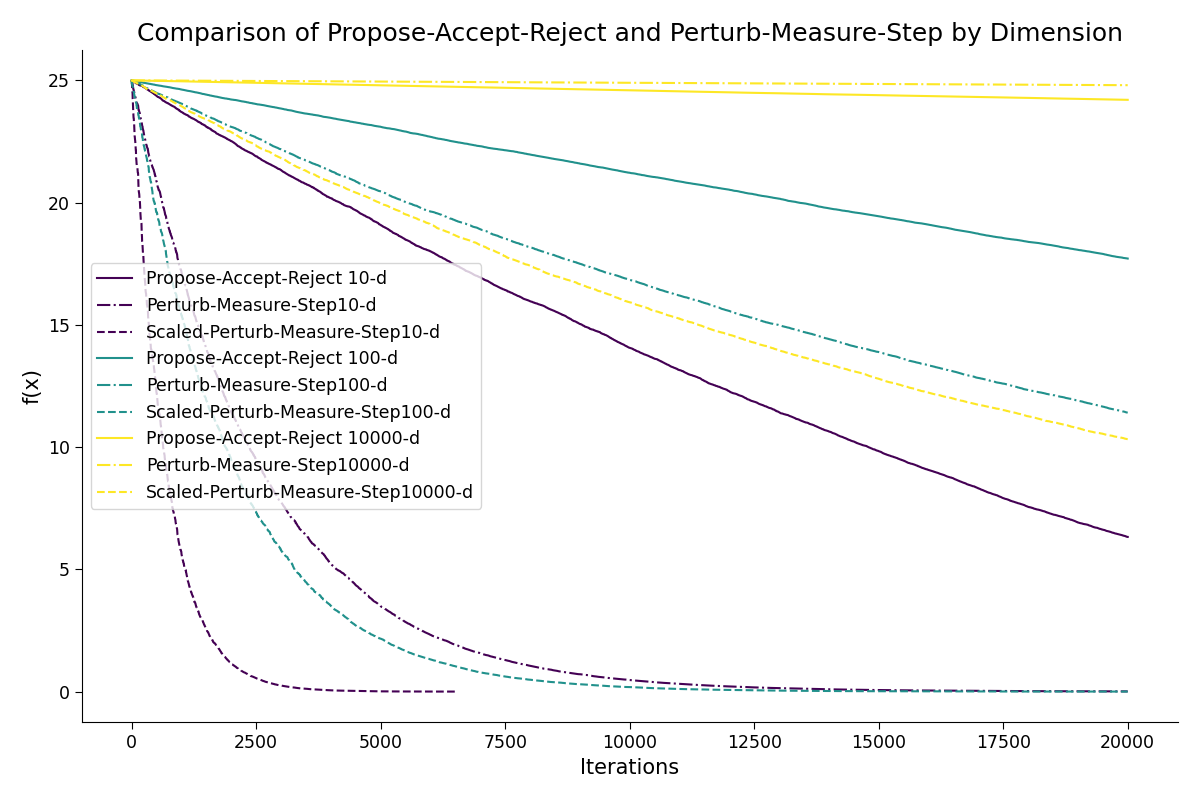

In [8]:
# @markdown **Run this cell** to compare convergence accross algorithms and dimensional scale.

def simple_quadratic(x):
  return np.sum(x**2)

def scale_stable_propose(x, step_size=0.1, rng=np.random.default_rng()):
  dim = x.shape[0]
  step_scale = step_size / np.sqrt(dim)
  proposed_x = x + rng.standard_normal(size=x.shape) * step_scale
  return proposed_x

# Propose-accept-reject loop
def propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(0)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    num_proposed = 1
    while z > step_size**2 and len(z_history) < max_proposals:
      proposed_x = scale_stable_propose(x, step_size=step_size, rng=par_rng)
      z_proposed = simple_quadratic(proposed_x)
      if z_proposed < z:
        x = proposed_x
        z = z_proposed
      z_history.append(z)
    histories.append(z_history)
  return histories

# Perturb-measure-step
def perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    num_steps = 0
    while z_history[-1] > step_size:
      for dim in range(N):
        x[dim] += test_perturb #perturb
        z_test = simple_quadratic(x) #test
        x[dim] -= test_perturb # un-perturb
        dim_grad_est = (z_test - z) / test_perturb #measure slope
        x[dim] -= step_scale * dim_grad_est #step
        num_steps += 1
        z = simple_quadratic(x)
        #num_function_evaluations += 2
        x_history.append(x)
        z_history.append(z)
        if num_steps > max_steps:
          break
      if num_steps > max_steps:
        break
    histories.append(z_history)
  return histories

def good_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

def scaling_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    dimensional_scale_factor = np.sqrt(np.pi * N / 2)
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

def over_scaling_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    dimensional_scale_factor = N # np.sqrt(np.pi * N / 2)
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

# Parameters
test_rng = np.random.default_rng(0)
N_Dim = [10, 100, 10000]
step_size = 0.001
max_proposals = 20000
max_steps = 20000
starting_distance_from_optimal = 5
test_perturb = 0.00001
step_scale = 0.001

# Collect data
z_par_histories = propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal)
#z_pms_histories = perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
z_gpms_histories = good_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
z_spms_histories = scaling_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
#z_ospms_histories = over_scaling_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)))

for ii, N in enumerate(N_Dim):
  evals_per_step = N + 1
  z_par_vals = z_par_histories[ii]
  #z_pms_vals = z_pms_histories[ii]
  z_gpms_vals = z_gpms_histories[ii]
  z_spms_vals = z_spms_histories[ii]
  #z_ospms_vals = z_ospms_histories[ii]
  # always just 2 evaluations per step for the chaotic-good perturb-measure-step
  ax.plot(z_par_vals, color=colors[ii], linestyle='-', label=f'Propose-Accept-Reject {N_Dim[ii]}-d')
  #ax.plot(z_pms_vals, color=colors[ii], linestyle='-.', label=f'Systematic-Perturb-Measure-Step{N_Dim[ii]}-d')
  ax.plot(z_gpms_vals, color=colors[ii], linestyle='-.', label=f'Perturb-Measure-Step{N_Dim[ii]}-d')
  ax.plot(z_spms_vals, color=colors[ii], linestyle='--', label=f'Scaled-Perturb-Measure-Step{N_Dim[ii]}-d')
#  ax.plot(z_ospms_vals, color=colors[ii], linestyle='-', label=f'Over-Scaling-Perturb-Measure-Step{N_Dim[ii]}-d')

ax.set_xlabel('Iterations')
ax.set_ylabel('f(x)')
ax.set_title('Comparison of Propose-Accept-Reject and Perturb-Measure-Step by Dimension')
ax.legend()

plt.show()

In accordance with our analysis above, for lower dimensions perturb-measure-step does better because the squared gradient term compensates for the $\frac{1}{n}$ drop off, but eventually as we go up to 10,000 dimensions in the figure above, propose-accept-reject becomes more efficient. At what scale one method become better than the other will of course depend on the details of the problem, but as might be expected, because perturb-measure-step uses estimates of the slope to inform its steps it is at an advantage when there are steep gradients to be informed by. The point though isn't really about which of perturb-measure-step or propose-accept-reject is better in higher dimensions, the point is they are both become ineffective as we move into higher-dimensional optimization problems.

On the face of it, it might seem like propose-accept-reject scales better to higher dimensions than does perturb-measure-step, and indeed in this simplified analysis it does. However, in practice, step sizes and step scaling factors are critical to the rate of convergence. Higher values allow for rapid traversal of the parameter space, while smaller steps allow for greater percision when dialing in the the exact loccation of the optima once the rough neighbourhood in parameter space has been reached. These algorithms can also fail to converge if step sizes become too large. Because the perturb-measure-step algorithm takes steps in proportion to the gradient, and (for analytic functions) the gradient gets close to zero near optima, it is generally possible to have a higher step-size scaling factor in perturb-measure-step than average step-sizes in propose-accept-reject.

In the version of perturb measure step above, we always take a step proportional to the rate of improvement in the sampled test direction. Now this rate of improvement is the product of two components, one is the magnitude of the gradient, $\| \mathbf{g} \|$ at the point $\mathbf{x}$, and the other is the alignment of the test direction with the gradient direction, this is given by $\frac{\xi_1}{\| \xi \|}$. Now for large $n$ the average value of $\frac{\xi_1}{\| \xi \|}$, is roughly $\sqrt{\frac{2}{n \pi}}$. This means that we can safely scale up our step sizes by the inverse of this amount, to (partially) compensate for the increasing lack of alignment between the gradient and a randomly chosen test direction in high dimensions. This leads to the scaled-perturb-measure-step in the plot above, which clearly outperforms the unscaled-perturb-measure-step and propose-accept-reject, with its expected improvement per step of:

$$ s\|\mathbf{g}\|^2 \sqrt{\frac{\pi}{2n}}$$

The best dimensional scaling we can achieve with either propose-accept-reject or perturb-measure-step in on the order of $\frac{1}{\sqrt{n}}$. So, if it takes $5$ iterations to solve find a good value in one dimension it will take $50 = 5 \cdot \sqrt{100}$ iterations to find as good a value in the $n=100$ dimension equivalent of the problem, $500 = 5 \cdot \sqrt{10000}$ to find as good a value in the $n=10000$ dimension equivalent of the problem, and so on.


# 2.1.3.4 Learning Strike-No-Strike with Perturb-Measure-Step.

We're going to conclude this sequence with a higher-dimensional version of our strike-no-strike problem. Whereas previously we had only a single input, now we are going to allow for 64 different inputs. So our cartoon organism that inspires this problem can now be thought of as having 64 photo-sensitive receptors, and based on this combination of inputs it must decide whether to strike or not. As before, the organism pays a cost of one if it strikes when it shouldn't and recieves a reward of one if it strikes when it should. It receives no cost or reward when it does not strike. To get a sense of this more complex discrimination problem, try it yourself by running the code cell below.

In [9]:
# @markdown **Run this cell** to try out the more complex 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.prev_fig, self.prev_ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.prev_fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    current_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    previous_feedback = widgets.VBox([self.prev_fig.canvas, self.feedback_display])
    self.ui = widgets.HBox([previous_feedback, current_buttons, self.score_display])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if self.current_index > 0:
      previous_image = self.features[self.current_index - 1]
    else:
      previous_image = np.zeros_like(image)

    if len(image) == 64:
        image = image.reshape(8, 8)
        previous_image = previous_image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      previous_scalar_value = previous_image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      previous_image = np.full((8, 8), -6.0)
      # Set the first ring to 6 (white)
      image[0, 0] = 6
      previous_image[0, 0] = 6
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      previous_image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      previous_image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
      previous_image[3:-3, 3:-3] = previous_scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.prev_fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.prev_ax = self.prev_fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.prev_ax.set_xlim(-.5, 7.5)
    self.prev_ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.prev_ax.set_aspect('equal')
    self.ax.axis('off')
    self.prev_ax.axis('off')
    self.ax.imshow(image, cmap='gray', vmin=-6, vmax=6)
    self.prev_ax.imshow(previous_image, cmap='gray', vmin=-6, vmax=6)
    self.ax.set_title('Current Sensory Input')
    self.prev_ax.set_title('Previous Sensory Input')
    self.fig.canvas.draw()
    self.prev_fig.canvas.draw()

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
display(scramble_bin_hard.prev_fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

Maybe you were able to solve this with som savant like abstract pattern recognition powers. We were not able to learn to discriminate between the strike and no-strike situations over a dozen or so trials. The point here is that this is a non-trivial discrimination to learn. However, it is, as we will see in the next bit of code, a discrimination that a simple artificial neural network can learn to solve. (As before The dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, (Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49).)

We model this creature's sensory-behaviour system much as before. Now, $\mathbf{x}$ is the raw sensory input (vector) of length 64 in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.

In [10]:
# the data set we're working with has 5620 example sensory inputs,
# each consisting of 64 values
print(Xs.shape)

(5620, 64)


In [11]:
# this is the first example
print(Xs[0].reshape(8,8,))

[[-1.5   0.   -4.5  -5.25  3.    5.25 -3.75 -6.  ]
 [-6.   -6.   -2.25 -0.75  4.5  -1.5  -6.   -6.  ]
 [-4.5  -6.   -6.   -6.   -6.   -6.   -0.75 -5.25]
 [-0.75  4.5  -3.75  0.75 -2.25 -1.5  -0.75  3.75]
 [-6.   -5.25  5.25  0.   -6.    1.5   3.   -0.75]
 [-6.   -6.   -6.   -6.   -5.25 -6.    3.75  6.  ]
 [-6.   -6.   -2.25 -6.   -6.    2.25 -6.   -1.5 ]
 [ 6.    6.   -6.   -6.   -3.   -6.    0.75 -6.  ]]


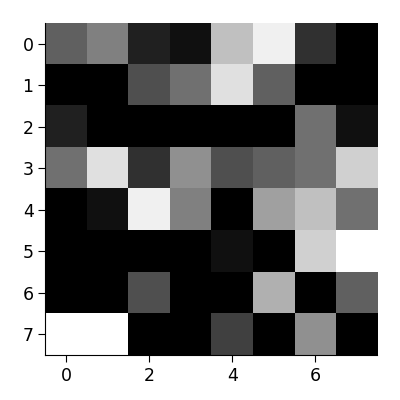

In [12]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$y = \mathbf{Wx} + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron, and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could also be thought of as a row vector.)  As before, the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Recall that $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

Given a reward of 1 for striking at the right time and a penalty of -1 for striking at the wrong time, we can use the following function to evaluate the the parameters $\mathbf{W}$ and $b$ of the network

In [13]:
# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_aug(W, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) # 1 x batch
  y_hat = np_sigmoid(h) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.sum(batch_expected_reward)
  if verbose:
    # Expected true positives (TP_e) and false positives (FP_e)
    TP_e = np.sum(y_hat * y)  # Probabilities where true label is 1
    FP_e = np.sum(y_hat * (1 - y))  # Probabilities where true label is 0
    # Expected false negatives (FN_e) and true negatives (TN_e)
    FN_e = np.sum((1 - y_hat) * y)  # (1 - probabilities) where true label is 1
    TN_e = np.sum((1 - y_hat) * (1 - y))  # (1 - probabilities) where true label is 0
    confusion_matrix = np.array([[TP_e, FN_e], [FP_e, TN_e]])
    table = [["Should Strike", TP_e, FN_e],
                 ["Shouldn't Strike", FP_e, TN_e]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Expected Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Expected reward: {R_bar}')
    return None
  else:
    return R_bar

W_test = np.zeros((1,65))
eval_params_aug(W_test, Xs_aug.T, y1.T)

19.0

In [14]:
# There are this many cases where striking is good
np.sum(y1 == 1)

2829

In [15]:
# And this many cases where striking is bad
np.sum(y1 == 0)

2791

In [16]:
# W = 0 should strike half the time no matter what,
# in which case would expect a reward of
(2829 - 2791) / 2

19.0

We have an evaluation function. Since a properly scaled perturb-measure-step algorithm was best in our analyses above, lets use our scaled-perturb-measure-step algorithm to find some good parameter values for the discrimination problem defined by this dataset.

In [17]:
# @title Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 100000
step_scale = 0.002
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for step in range(num_steps):
  R_current = eval_params_aug(W, Xs_aug.T, y1.T)
  W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,65))
  raw_test_perturb = rng.standard_normal(size=(1,65))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  R_test = eval_params_aug(W + test_perturbation, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if step == 0 or (step + 1) % 3000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Current Total Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_aug(W, Xs_aug.T, y1.T, verbose=True)

Step 1/100000 completed | Current Total Reward: 19.000000 | Time elapsed: 0.01 seconds
Step 3000/100000 completed | Current Total Reward: 2346.136072 | Time elapsed: 4.50 seconds
Step 6000/100000 completed | Current Total Reward: 2400.553644 | Time elapsed: 7.61 seconds
Step 9000/100000 completed | Current Total Reward: 2424.489099 | Time elapsed: 10.29 seconds
Step 12000/100000 completed | Current Total Reward: 2439.002522 | Time elapsed: 13.86 seconds
Step 15000/100000 completed | Current Total Reward: 2443.190655 | Time elapsed: 17.03 seconds
Step 18000/100000 completed | Current Total Reward: 2456.706140 | Time elapsed: 19.63 seconds
Step 21000/100000 completed | Current Total Reward: 2458.793276 | Time elapsed: 22.36 seconds
Step 24000/100000 completed | Current Total Reward: 2460.361419 | Time elapsed: 25.44 seconds
Step 27000/100000 completed | Current Total Reward: 2463.191183 | Time elapsed: 28.37 seconds
Step 30000/100000 completed | Current Total Reward: 2463.539875 | Time e

The best possible score is 2829, and perturb measure step is able to discover network parameters that achieve a score of roughly 2480, in 100,000 steps. This is pretty good, better than we the humans were able to do in terms of figuring out the pattern. We are cheating a tiny bit in the sense that we said that the striking behaviour was stochastically determined and we are using the exact expected reward to inform our parameter updates instead of a noisy sample based on actually selecting one behaviour instead of another. We will address this detail in the next sequence.

Now whenever we look at the performance of a model, we have to ask ourselves, is it not getting better because our training algorithm can't make the model any better, or is the *expressivity* of the model maxed out, and given the structural limitations (basically the number of parameters in our model and how they combine to produce outputs that are contingent on inputs). Could such a model ever do any better? It turns out that this is roughly about as good as can be expected with a network as simple as this. The next question then is, can we do better with a more complex network? Let's see

# 2.1.3.4 Is Solving High Dimensional Optimization Problem Necissary for Adaptive Behaviour? Hard Yes.

One reason for having a large, flexible brain is to produce complex behaviour that is contingent on the state of the world in complex ways. Our simple strike-no-strike network, consisted of a single layer of synaptic connections between the sensory inputs and the motor outputs. In a shallow network structure like this a sensory input either directly inhibits or promotes the striking behaviour, there is no possibility for the a sensory input to promote striking in some sensory contexts, but inhibit it in others. This is a deficincy. Context is important, loud thumping and roaring noises at a concert means the band is good, similar noises when camping in the wilderness means a large animal is nearby. A shallow network does not allow for such context dependence. However, by simply adding an additional layer to the network, consisting of some intermediate (hidden) neurons between the inputs and the output, limited forms of context dependent inhibition and promotion of striking are possible.

One thing that could be holding back performance on this discrimination problem is that our algorithms are not capable of finding the optimal parameters for the given model, but... we don't really think that is the case here. Another possibility is that our simple sensory-behaviour circuit is not flexible or complex enough to fully discriminate between the two types of input. There is good reason to think that this might be the case. Our current sensory-behavioural circuit is effectively equivalent to logistic regression, i.e. each feature can either inhibit or potentiate striking behaviour to varying degrees, but there is no possibility for conditional interaction between features. By 'conditional interaction,' we mean a scenario where, for instance, feature 1 typically inhibits the behavior, except when feature 2 is positive, under which condition feature 1 becomes potentiating. These kinds of feature interactions are impossible in the current model. One way to allow for such interactions is to augment the base set of features with composite features, e.g. incorporate all the pairwise products of the existing feature set, so that instead of 65 features (bias included) we have $(65^2 - 1) = 4224$ features to work with. This could work, but what if we want something that depends on the interaction of more than 2 features, adding higher order polynomial terms will quickly make the problem intractable (Reference appendix section on why hidden layers not polynomials if we do that). If we had some mechanistically grounded understanding or hypothesis about the relationship between the features and label could might be able to cherry pick some small subset of higher order interaction terms, but the ML/supervised learning framework is in large part about automating the feature selection processes based on the data alone. In turns out that instead of resorting the regression on polynomial terms to capture feature interactions, there is a much more compact and expressive way of allowing for feature interactions. The idea is to allow for feature interactions to emerge as needed in a 'hidden' computational layer of our highly abstracted neurons.

Our new strike-no-strike network with 1 hidden layer is structured as follows

As before $\mathbf{x}$ is the raw sensory input (vector) in a given episode and each element of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.
These input neurons are then connected by synapses to a 'hidden layer' of intermediate computational neurons, say 10 of them. The activation level of these hidden layer neurons is computed as
$$\mathbf{h} = \sigma(\mathbf{W}_{in} \cdot \mathbf{x})$$
Now $\mathbf{W}_{in}$ is a matrix of synaptic weights between the input neurons and the hidden layer neurons, and $\cdot$ denotes standard matrix vector multiplication. (In this case $\mathbf{W}$ has shape $10 \times 65$. Each the values in the $i^{th}$ row of $\mathbf{W}_{in}$ given the sign and strength of the connections coming into the $i^{th}$ element of $h$ and similarly each value in the $j^{th}$ column of $\mathbf{W}_{in}$ corresponds to connection strengths coming out of the $j^{th}$ sensory input neuron.)  We still us $\sigma$ to represent the standard logistic sigmoid function, but in these case applied elementwise the vector output of the product $\mathbf{W}_{in} \cdot \mathbf{x}$. Then much as before our striking probability is computed as
$$y = \mathbf{W}_{out} \cdot \mathbf{h}$$
and
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$
Here $\mathbf{W}_{out}$ has shape $1  \times 10$.


We will need to write a new eval params function for this new model, let's do it.

In [18]:
def eval_params_hidden(W_in, W_out, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W_in: (hidden-neurons(20) x inputs(65) np.array)
           weights between sensory neurons and hidden layer neurons
    W_out: (output(1) x hidden-neurons(20) np.array)
           weights between hidden layer neurons and output
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np_sigmoid(np.dot(W_in,x)) # hidden x batch
  y_hat = np_sigmoid(np.dot(W_out,h)) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.sum(batch_expected_reward)
  if verbose:
    # Expected true positives (TP_e) and false positives (FP_e)
    TP_e = np.sum(y_hat * y)  # Probabilities where true label is 1
    FP_e = np.sum(y_hat * (1 - y))  # Probabilities where true label is 0
    # Expected false negatives (FN_e) and true negatives (TN_e)
    FN_e = np.sum((1 - y_hat) * y)  # (1 - probabilities) where true label is 1
    TN_e = np.sum((1 - y_hat) * (1 - y))  # (1 - probabilities) where true label is 0
    confusion_matrix = np.array([[TP_e, FN_e], [FP_e, TN_e]])
    table = [["Should Strike", TP_e, FN_e],
                 ["Shouldn't Strike", FP_e, TN_e]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Expected Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Expected reward: {R_bar}')
    return None
  else:
    return R_bar


We've got a more complicated circuit with more parameters, how much longer does it take us to evaluate this circuit compared to our previous one?

In [19]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug.T, y1.T)

417 µs ± 120 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
W_in = np.zeros((10,65))
W_out = np.zeros((1,10))
%timeit eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)

2.21 ms ± 565 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Roughly 5x longer per function evaluation, which means not only will we likely need more iterations of our algorithm because it is harder to find good parameters in high dimensions (we have 660 parameters now, which is a lot more than 65), but also each of those steps will take longer to process because function evaluations are also more costly. It will all be worth it if we can get better final performance though.

In [21]:
# @title 10 Hidden Units - Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 30000
step_scale = 0.025
perturbation_scale = 0.0001 # std of gaussian test perturbations
num_hidden_units = 10
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
flat_params = np.concatenate((W_in_init.flatten(), W_out_init.flatten()))
dimensional_scale_factor = np.sqrt(len(flat_params))
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for step in range(num_steps):
  W_in, W_out = np.split(flat_params, [650])
  W_in = W_in.reshape((10,65))
  W_out = W_out.reshape((1,10))
  R_current = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  raw_param_perturb = learn_rng.standard_normal(size=len(flat_params))
  unit_param_perturb = raw_param_perturb / np.linalg.norm(raw_param_perturb.flatten())
  test_perturbation = unit_param_perturb * perturbation_scale
  perturbed_flat_params = flat_params + test_perturbation
  W_in_test, W_out_test = np.split(perturbed_flat_params, [650])
  W_in_test = W_in_test.reshape((10,65))
  W_out_test = W_out_test.reshape((1,10))
  R_test = eval_params_hidden(W_in_test, W_out_test, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  flat_params += step_scale * dimensional_scale_factor * directional_grad_est * unit_param_perturb

  if step == 0 or (step + 1) % 1000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Current Total Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
W_in, W_out = np.split(flat_params, [650])
W_in = W_in.reshape((10,65))
W_out = W_out.reshape((1,10))
eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T, verbose=True)


Step 1/30000 completed | Current Total Reward: 31.731627 | Time elapsed: 0.01 seconds
Step 1000/30000 completed | Current Total Reward: 2410.136651 | Time elapsed: 5.46 seconds
Step 2000/30000 completed | Current Total Reward: 2520.694713 | Time elapsed: 11.24 seconds
Step 3000/30000 completed | Current Total Reward: 2508.277259 | Time elapsed: 16.90 seconds
Step 4000/30000 completed | Current Total Reward: 2545.601873 | Time elapsed: 23.92 seconds
Step 5000/30000 completed | Current Total Reward: 2565.640457 | Time elapsed: 29.49 seconds
Step 6000/30000 completed | Current Total Reward: 2595.772103 | Time elapsed: 34.19 seconds
Step 7000/30000 completed | Current Total Reward: 2620.777221 | Time elapsed: 39.63 seconds
Step 8000/30000 completed | Current Total Reward: 2615.879300 | Time elapsed: 44.84 seconds
Step 9000/30000 completed | Current Total Reward: 2602.595215 | Time elapsed: 49.75 seconds
Step 10000/30000 completed | Current Total Reward: 2593.151727 | Time elapsed: 54.88 se

So this new, more complex circuit is great. We're much closer to the theoretical maximum performance of 2829, maybe with a few more hidden units, and a little longer training time we could have perfect discrimination. Let's see what happens when we go up to 20 hidden units. As a heads up this is going to take awhile (about 3 minutes) so you should read ahead while waiting for this training loop to complete

In [22]:
# @title 20 Hidden Units - Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 10000
step_scale = 0.025
perturbation_scale = 0.0001 # std of gaussian test perturbations
num_hidden_units = 20
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (num_hidden_units + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
flat_params = np.concatenate((W_in_init.flatten(), W_out_init.flatten()))
dimensional_scale_factor = np.sqrt(len(flat_params))
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for step in range(num_steps):
  W_in, W_out = np.split(flat_params, [num_hidden_units*65])
  W_in = W_in.reshape((num_hidden_units,65))
  W_out = W_out.reshape((1,num_hidden_units))
  R_current = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  raw_param_perturb = learn_rng.standard_normal(size=len(flat_params))
  unit_param_perturb = raw_param_perturb / np.linalg.norm(raw_param_perturb.flatten())
  test_perturbation = unit_param_perturb * perturbation_scale
  perturbed_flat_params = flat_params + test_perturbation
  W_in_test, W_out_test = np.split(perturbed_flat_params, [num_hidden_units*65])
  W_in_test = W_in_test.reshape((num_hidden_units,65))
  W_out_test = W_out_test.reshape((1,num_hidden_units))
  R_test = eval_params_hidden(W_in_test, W_out_test, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  flat_params += step_scale * dimensional_scale_factor * directional_grad_est * unit_param_perturb

  if step == 0 or (step + 1) % 500 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Current Total Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
W_in, W_out = np.split(flat_params, [num_hidden_units*65])
W_in = W_in.reshape((num_hidden_units,65))
W_out = W_out.reshape((1,num_hidden_units))
eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T, verbose=True)


Step 1/10000 completed | Current Total Reward: 40.177554 | Time elapsed: 0.01 seconds
Step 500/10000 completed | Current Total Reward: 2378.883243 | Time elapsed: 4.70 seconds
Step 1000/10000 completed | Current Total Reward: 2465.113952 | Time elapsed: 9.13 seconds
Step 1500/10000 completed | Current Total Reward: 2506.818897 | Time elapsed: 14.01 seconds
Step 2000/10000 completed | Current Total Reward: 2556.139927 | Time elapsed: 18.34 seconds
Step 2500/10000 completed | Current Total Reward: 2569.795382 | Time elapsed: 23.01 seconds
Step 3000/10000 completed | Current Total Reward: 2566.176149 | Time elapsed: 27.27 seconds
Step 3500/10000 completed | Current Total Reward: 2590.611978 | Time elapsed: 31.77 seconds
Step 4000/10000 completed | Current Total Reward: 2576.977206 | Time elapsed: 36.70 seconds
Step 4500/10000 completed | Current Total Reward: 2570.213100 | Time elapsed: 41.16 seconds
Step 5000/10000 completed | Current Total Reward: 2586.035732 | Time elapsed: 45.38 secon

This more complex circuit gets us even closer to the theoretical maximum performance of 2829, but it's taking longer to get there. This is a consequence of both, the function evaluations required at each step being slower (for the more complex function) and because more iterations are needed to effectively search the higher dimensional space for a good configuration of $\mathbf{W}_{in}$ and $\mathbf{W}_{out}$. With even more hidden units and more time we can likely learn perfect discrimination, but it will take even longer (more than 3 minutes!).

Although the toy neural circuit models in this sequence are a far cry from actual neural circuits, they still provide insight into possible mechanisms of synaptic plasticity the brain. We can imagine a scenario where synaptic strengths between neurons in a circuit undergo small, transient perturbations. The brain might integrate and compare the performance of these perturbations over a learning episode (for example, a day) to previous performance levels. (Ee leave aside the specifics of how this integration and comparison occur for now.)

If performance improves with a perturbation, synaptic changes could be consolidated in the direction of the perturbation, proportionate to the degree of improvement. Conversely, if performance worsens, changes might be consolidated in the opposite direction, also proportional to the performance decrease. This concept, while still vague, suggests a mechanism of synaptic adjustment based on performance feedback.

One critical point to consider is the scalability of such a learning process. The number of learning episodes required for effective optimization grows with the number of parameters in a neural circuit. This implies that 'perturb-measure-step' plasticity cannot be the primary mechanism driving neural plasticity in large, complex neural circuits that learn rapidly. This limitation is critical, the lifetimes of most animals simply aren't long enough to accommodate the number of learning iterations needed for extensive optimization.

However, as demonstrated above, a more complex circuit achieved significantly better performance in the discrimination task, so large complex circuits can be useful. This suggests that even if empirical evidence of perturbation-based learning in the brain exists and its physiological implementation is understood, such processes are unlikely to be the primary drivers of neural plasticity for complex and challenging behaviors.

(One counterargument in favor of simple learning rules is that extensive learning might not be necessary if genetic predisposition starts the circuit off close to an optimal parameter configuration. Then subsequently, relatively slow learning processes could 'fine-tune' the neural circuit's configuration. However, as noted in our earlier discussions on evolution, changing environments necessitate that a significant portion of behavior must emerge from learning, thereby limiting the extent to which genetic predispositions can facilitate efficient and adaptive learning.)

In the next sequence we will explore the relationship between perturb-measure-step updates and the gradient in even more detail, show how this together with stochastic function evaluation enable introduce the idea of stochastic function e